## Computational complexity

$O(1) - Constant$ O(1)
$O(\log{}n) - Logarithmic$ O(log_n)
$O(n) - Linear$ O(n)
$O(n^2) - Quadratic$ O(n2)
$O(n^3) - Cubic$ O(n3)
$O(n\log{}n) - N log n$ O(n_log_n)


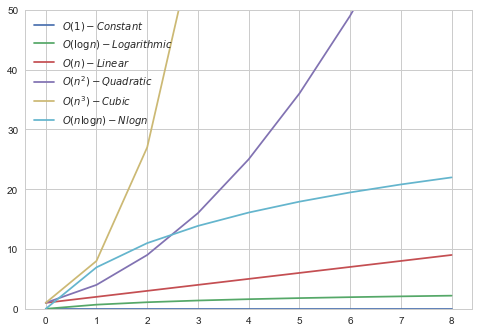

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Setting the style of the plot
plt.style.use('seaborn-whitegrid')

# Creating an array of input sizes
n = 10
x = np.arange(1, n)

# Creating a pandas data frame for popular complexity classes
df = pd.DataFrame({'x': x,
                   'O(1)': 0,
                   'O(n)': x,
                   'O(log_n)': np.log(x),
                   'O(n_log_n)': n * np.log(x),
                   'O(n2)': np.power(x, 2), # Quadratic
                   'O(n3)': np.power(x, 3)}) # Cubic

# Creating labels
labels = ['$O(1) - Constant$',
          '$O(\log{}n) - Logarithmic$',
          '$O(n) - Linear$',
          '$O(n^2) - Quadratic$',
          '$O(n^3) - Cubic$',
          '$O(n\log{}n) - N log n$']

# Plotting every column in dataframe except 'x'
for i, col in enumerate(df.columns.drop('x')):
    print(labels[i], col)
    plt.plot(df[col], label=labels[i])

# Adding a legend
plt.legend()

# Limiting the y-axis
plt.ylim(0,50)

plt.show()

### Simple measure of training and scoring time 

In [2]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer():
    s = time()
    yield
    e = time() - s
    print("{0}: {1} ms".format('Elapsed time', e))

In [3]:
import numpy as np

with timer():
    X = np.random.rand(1000)

Elapsed time: 0.0008311271667480469 ms


In [4]:
from sklearn.neighbors import KNeighborsClassifier

# Defining properties of dataset
nT = 100000000 # Total number of values in our dataset
nF = 10 # Number of features
nE = int(nT / nF) # Number of examples

# Creating n x m matrix where n=100 and m=10
X = np.random.rand(nT).reshape(nE, nF)

# This will be a binary classification with labels 0 and 1
y = np.random.randint(2, size=nE)

# Data that we are going to score
scoring_data = np.random.rand(nF).reshape(1,-1)

# Create KNN classifier
knn = KNeighborsClassifier(11, algorithm='brute')

# Measure training time
with timer():
    knn.fit(X, y)

# Measure scoring time
with timer():
    knn.predict(scoring_data)

Elapsed time: 1.0686137676239014 ms
Elapsed time: 0.416409969329834 ms


In [5]:
from sklearn.linear_model import LogisticRegression
log_res = LogisticRegression(C=1e5)

with timer():
    log_res.fit(X, y)

with timer():
    prediction = log_res.predict(scoring_data)

Elapsed time: 12.797266006469727 ms
Elapsed time: 0.00014019012451171875 ms


### Code profiling in Python

In [6]:
# cProfile
import cProfile

cProfile.run('np.std(np.random.rand(1000000))')

         23 function calls in 0.016 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.016    0.016 <string>:1(<module>)
        1    0.000    0.000    0.003    0.003 _methods.py:133(_std)
        1    0.000    0.000    0.000    0.000 _methods.py:43(_count_reduce_items)
        1    0.002    0.002    0.003    0.003 _methods.py:86(_var)
        1    0.000    0.000    0.003    0.003 fromnumeric.py:2960(std)
        2    0.000    0.000    0.000    0.000 numeric.py:495(asanyarray)
        1    0.000    0.000    0.016    0.016 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
        4    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.issubclass}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.max}
        2    0.000   

#### Following code snippet should be put into profiler_example_1.py

import numpy as np

np.std(np.random.rand(1000000))

#### Then from your terminal you should run the following command

python -m cProfile -o profiler_output -s cumulative profiler_example_1.py

### Visualizing performance statistics

#### To visualize results, you should run the following command from your terminal

snakeviz profiler_output

## K-Nearest Neighbours from scratch

Save below code block as knn_prediction.py

In [ ]:
import numpy as np
import operator

# distance module includes various distance functions
# You will use euclidean distance function to calculate distances between scoring input and training dataset.
from scipy.spatial import distance

# Decorating function with @profile to get run statistics
@profile
def nearest_neighbors_prediction(x, data, labels, k):

    # Euclidean distance will be calculated between example to be predicted and examples in data
    distances = np.array([distance.euclidean(x, i) for i in data])

    label_count = {}
    for i in range(k):
        # Sorting distances starting from closest to our example
        label = labels[distances.argsort()[i]]
        label_count[label] = label_count.get(label, 0) + 1
    votes = sorted(label_count.items(), key=operator.itemgetter(1), reverse=True)

    # Return the majority vote
    return votes[0][0]

# Setting seed to make results reproducible
np.random.seed(23)

# Creating dataset, 20 x 5 matrix which means 20 examples with 5 features for each
data = np.random.rand(100).reshape(20,5)

# Creating labels
labels = np.random.choice(2, 20)

# Scoring input
x = np.random.rand(5)

# Predicting class for scoring input with k=2
pred = nearest_neighbors_prediction(x, data, labels, k=2)
# Output is ‘0’ in my case

### Profiling your Python script line by line

#### Run the following command from your terminal

kernprof -l knn_prediction.py

#### To see the results, run the following command from your terminal

python -m line_profiler knn_prediction.py.lprof

## Linearity versus non-linearity

### Decision Boundaries

In [14]:
import matplotlib.cm as cm

# This function will scale training datatse and train given classifier.
# Based on predictions it will draw decision boundaries.

def draw_decision_boundary(clf, X, y, h = .01, figsize=(9,9), boundary_cmap=cm.winter, points_cmap=cm.cool):

    # After you apply StandardScaler, feature means will be removed and all features will have unit variance.
    from sklearn.preprocessing import StandardScaler
    X = StandardScaler().fit_transform(X)

    # Splitting dataset to train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

    # Training given estimator on training dataset by invoking fit function.
    clf.fit(X_train, y_train)

    # Each estimator has a score function.
    # Score will show you estimator's performance by showing metric suitable to given classifier.
    # For example, for linear regression, it will output coefficient of determination R^2 of the prediction.
    # For logistic regression, it will output mean accuracy.

    score = clf.score(X_test, y_test)
    print("Score: %0.3f" % score)

    # Predict function of an estimator, will predict using trained model
    pred = clf.predict(X_test)

    # Figure is a high-level container that contains plot elements
    figure = plt.figure(figsize=figsize)

    # In current figure, subplot will create Axes based on given arguments (nrows, ncols, index)
    ax = plt.subplot(1, 1, 1)

    # Calculating min/max of axes
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Meshgrid is usually used to evaluate function on grid.
    # It will allow you to create points to represent the space you operate
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Generate predictions for all the point-pair created by meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # This will draw boundary
    ax.contourf(xx, yy, Z, cmap=boundary_cmap)

    # Plotting training data
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=points_cmap, edgecolors='k')

    # Potting testing data
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=points_cmap, alpha=0.6, edgecolors='k')

    # Showing your masterpiece
    figure.show()

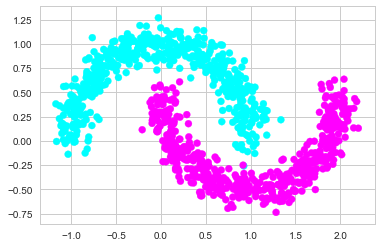

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# sklearn.linear_model includes regression models where target variable is a linear combination of input variables
from sklearn.linear_model import LogisticRegression

# make_moons is another useful function to generate sample data
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)

# Plot sample data
plt.scatter(X[:,0], X[:,1], c=y, cmap=cm.cool)
plt.show()

Score: 0.840


/Users/umitcakmak/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


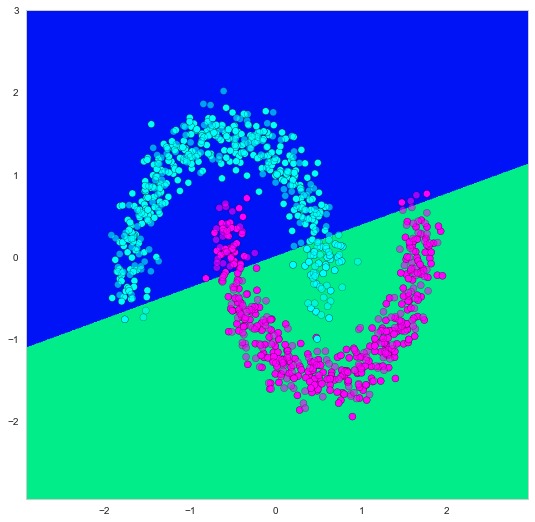

In [16]:
draw_decision_boundary(LogisticRegression(), X, y)

Score: 0.993


/Users/umitcakmak/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


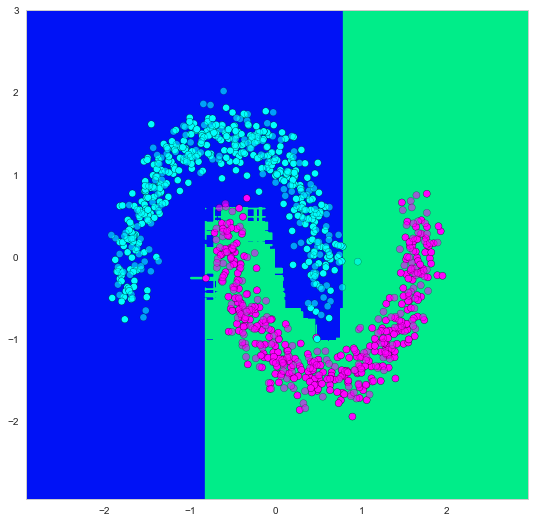

In [17]:
from sklearn.ensemble import RandomForestClassifier

draw_decision_boundary(RandomForestClassifier(), X, y)

In [18]:
from autosklearn.classification import AutoSklearnClassifier
AutoSklearnClassifier?

**Preceeding command will give you the following output**

Init signature: AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=360, initial_configurations_via_metalearning=25, ensemble_size=50, ensemble_nbest=50, seed=1, ml_memory_limit=3072, include_estimators=None, exclude_estimators=None, include_preprocessors=None, exclude_preprocessors=None, resampling_strategy='holdout', resampling_strategy_arguments=None, tmp_folder=None, output_folder=None, delete_tmp_folder_after_terminate=True, delete_output_folder_after_terminate=True, shared_mode=False, disable_evaluator_output=False, get_smac_object_callback=None, smac_scenario_args=None)
Docstring:      This class implements the classification task.
Init docstring:

Parameters

time_left_for_this_task : int, optional (default=3600)
    Time limit in seconds for the search of appropriate
    models. By increasing this value, *auto-sklearn* has a higher
    chance of finding better models.

per_run_time_limit : int, optional (default=360)
    Time limit for a single call to the machine learning model.
    Model fitting will be terminated if the machine learning
    algorithm runs over the time limit. Set this value high enough ...
    ...
    
...

## Supervised AutoML

In [19]:
# Importing necessary variables
import numpy as np
import pandas as pd
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.regression import AutoSklearnRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import wget
import pandas as pd

# Machine learning algorithms work with numerical inputs and you need to transform all non-numerical inputs to numerical ones
# Following snippet encode the categorical variables

link_to_data = 'https://apsportal.ibm.com/exchange-api/v1/entries/8044492073eb964f46597b4be06ff5ea/data?accessKey=9561295fa407698694b1e254d0099600'
filename = wget.download(link_to_data)

print(filename)
# GoSales_Tx_NaiveBayes.csv

df = pd.read_csv('GoSales_Tx_NaiveBayes.csv')
df.head()

GoSales_Tx_NaiveBayes.csv


,PRODUCT_LINE,GENDER,AGE,MARITAL_STATUS,PROFESSION
0,Personal Accessories,M,27,Single,Professional
1,Personal Accessories,F,39,Married,Other
2,Mountaineering Equipment,F,39,Married,Other
3,Personal Accessories,F,56,Unspecified,Hospitality
4,Golf Equipment,M,45,Married,Retired


In [20]:
df = df.apply(LabelEncoder().fit_transform)
df.head()


,PRODUCT_LINE,GENDER,AGE,MARITAL_STATUS,PROFESSION
0,4,1,10,1,3
1,4,0,22,0,2
2,2,0,22,0,2
3,4,0,39,2,1
4,1,1,28,0,5


In [21]:
# Function below will encode the target variable if needed
def encode_target_variable(df=None, target_column=None, y=None):

    # Below section will encode target variable if given data is pandas dataframe
    if df is not None:
        df_type = isinstance(df, pd.core.frame.DataFrame)

        # Splitting dataset as train and test data sets
        if df_type:

            # If column data type is not numeric then labels are encoded
            if not np.issubdtype(df[target_column].dtype, np.number):
                le = preprocessing.LabelEncoder()
                df[target_column] = le.fit_transform(df[target_column])
                return df[target_column]

            return df[target_column]
    # Below section will encode numpy array.
    else:

        # numpy array's data type is not numeric then labels are encoded
        if not np.issubdtype(y.dtype, np.number):
            le = preprocessing.LabelEncoder()
            y = le.fit_transform(y)
            return y

        return y


# Create a wrapper function where you can specify the type of learning problem
def supervised_learner(type, X_train, y_train, X_test, y_test):

    if type == 'regression':
        # You can play with time related arguments for discovering more pipelines
        automl = AutoSklearnRegressor(time_left_for_this_task=7200, per_run_time_limit=720)
    else:
        automl = AutoSklearnClassifier(time_left_for_this_task=7200, per_run_time_limit=720)

    # Training estimator based on learner type
    automl.fit(X_train, y_train)

    # Predicting labels on test data
    y_hat = automl.predict(X_test)

    # Calculating accuracy_score
    metric = accuracy_score(y_test, y_hat)

    # Return model, labels and metric
    return automl, y_hat, metric

# In function below, you need to provide numpy array or pandas dataframe together with the name of the target column as arguments
def supervised_automl(data, target_column=None, type=None, y=None):

    # First thing is to check wheter data is pandas dataframe
    df_type = isinstance(data, pd.core.frame.DataFrame)

    # Based on data type, you will split dataset as train and test data sets
    if df_type:
        # This is where encode_target_variable function is used before data split
        data[target_column] = encode_target_variable(data, target_column)
        X_train, X_test, y_train, y_test = \
            train_test_split(data.loc[:, data.columns != target_column], data[target_column], random_state=1)
    else:
        y_encoded = encode_target_variable(y=y)
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1)

    # If learner type is given, then you invoke supervied_learner
    if type != None:
        automl, y_hat, metric = supervised_learner(type, X_train, y_train, X_test, y_test)

    # If type of learning problem is not given, you need to infer it
    # If there are more than 10 unique numerical values, problem will be treated as regression problem,
    # Otherwise, classification problem

    elif len(df[target_column].unique()) > 10:
            print("""There are more than 10 uniques numerical values in target column. 
            Treating it as regression problem.""")
            automl, y_hat, metric = supervised_learner('regression', X_train, y_train, X_test, y_test)
    else:
        automl, y_hat, metric = supervised_learner('classification', X_train, y_train, X_test, y_test)

    # Return model, labels and metric
    return automl, y_hat, metric

In [ ]:
automl, y_hat, metric = supervised_automl(df, target_column='PRODUCT_LINE')

In [ ]:
automl.get_models_with_weights()

In [ ]:
# kddcup 99 dataset which is tcpdump portions of the 1998 DARPA Intrusion Detection System (IDS) Evaluation dataset.
# Goal is to detect network intrusions
from sklearn.datasets import fetch_kddcup99

# Downloading subset of whole dataset
dataset = fetch_kddcup99(subset='http', shuffle=True, percent10=True)
# Downloading https://ndownloader.figshare.com/files/5976042
# [INFO] [17:43:19:sklearn.datasets.kddcup99] Downloading https://ndownloader.figshare.com/files/5976042

X = dataset.data
y = dataset.target

# 58725 examples with 3 features
X.shape
# (58725, 3)

y.shape
(58725,)

# 5 different classes to represent network anolmaly
pprint(np.unique(y))
# array([b'back.', b'ipsweep.', b'normal.', b'phf.', b'satan.'], dtype=object)

automl, y_hat, metric = supervised_automl(X, y=y, type='classification')

## Unsupervised AutoML

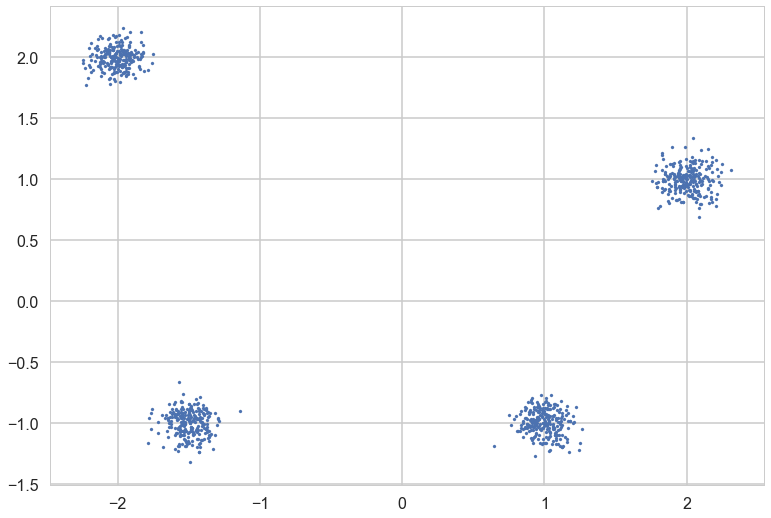

In [22]:
# Importing necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set context helps you to adjust things like label size, lines and various elements
# Try "notebook", "talk" or "paper" instead of "poster" to see how it changes
sns.set_context('poster')

# set_color_codes will affect how colors such as 'r', 'b', 'g' will be interpreted
sns.set_color_codes()

# Plot keyword arguments will allow you to set things like size or line width to be used in charts.
plot_kwargs = {'s': 10, 'linewidths': 0.1}

import numpy as np
import pandas as pd

# Pprint will better output your variables in console for readability
from pprint import pprint


# Creating sample dataset using sklearn samples_generator
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Make blobs will generate isotropic Gaussian blobs
# You can play with arguments like center of blobs, cluster standard deviation
centers = [[2, 1], [-1.5, -1], [1, -1], [-2, 2]]
cluster_std = [0.1, 0.1, 0.1, 0.1]

# Sample data will help you to see your algorithms behavior
X, y = make_blobs(n_samples=1000,
                  centers=centers,
                  cluster_std=cluster_std,
                  random_state=53)

# Plot generated sample data
plt.scatter(X[:, 0], X[:, 1], **plot_kwargs)
plt.show()

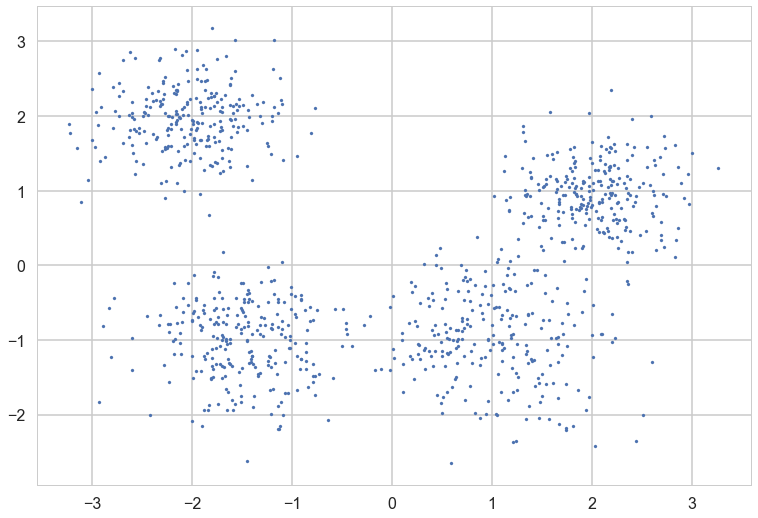

In [23]:
cluster_std = [0.4, 0.5, 0.6, 0.5] 

X, y = make_blobs(n_samples=1000,
                  centers=centers,
                  cluster_std=cluster_std,
                  random_state=53)

plt.scatter(X[:, 0], X[:, 1], **plot_kwargs)
plt.show()

In [55]:
class Unsupervised_AutoML:

    def __init__(self, estimators=None, transformers=None):
        self.estimators = estimators
        self.transformers = transformers
        pass
    
    def fit_predict(self, X, y=None):
        """
        fit_predict will train given estimator(s) and predict cluster membership for each sample
        """

        # This dictionary will hold predictions for each estimator
        predictions = []
        performance_metrics = {}

        for estimator in self.estimators:
            labels = estimator['estimator'](*estimator['args'], **estimator['kwargs']).fit_predict(X)
            estimator['estimator'].n_clusters_ = len(np.unique(labels))
            metrics = self._get_cluster_metrics(estimator['estimator'].__name__, estimator['estimator'].n_clusters_, X, labels, y)
            predictions.append({estimator['estimator'].__name__: labels})
            performance_metrics[estimator['estimator'].__name__] = metrics
            
        self.predictions = predictions
        self.performance_metrics = performance_metrics

        return predictions, performance_metrics
    
    # Printing cluster metrics for given arguments
    def _get_cluster_metrics(self, name, n_clusters_, X, pred_labels, true_labels=None):
        from sklearn.metrics import homogeneity_score, \
            completeness_score, \
            v_measure_score, \
            adjusted_rand_score, \
            adjusted_mutual_info_score, \
            silhouette_score

        print("""################## %s metrics #####################""" % name)
        if len(np.unique(pred_labels)) >= 2:

            silh_co = silhouette_score(X, pred_labels)

            if true_labels is not None:

                h_score = homogeneity_score(true_labels, pred_labels)
                c_score = completeness_score(true_labels, pred_labels)
                vm_score = v_measure_score(true_labels, pred_labels)
                adj_r_score = adjusted_rand_score(true_labels, pred_labels)
                adj_mut_info_score = adjusted_mutual_info_score(true_labels, pred_labels)

                metrics = {"Silhouette Coefficient": silh_co,
                           "Estimated number of clusters": n_clusters_,
                           "Homogeneity": h_score,
                           "Completeness": c_score,
                           "V-measure": vm_score,
                           "Adjusted Rand Index": adj_r_score,
                           "Adjusted Mutual Information": adj_mut_info_score}

                for k, v in metrics.items():
                    print("\t%s: %0.3f" % (k, v))

                return metrics

            metrics = {"Silhouette Coefficient": silh_co,
                       "Estimated number of clusters": n_clusters_}

            for k, v in metrics.items():
                print("\t%s: %0.3f" % (k, v))

            return metrics

        else:
            print("\t# of predicted labels is {}, can not produce metrics. \n".format(np.unique(pred_labels)))
            
    # plot_clusters will visualize the clusters given predicted labels
    def plot_clusters(self, estimator, X, labels, plot_kwargs):

        palette = sns.color_palette('deep', np.unique(labels).max() + 1)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

        plt.scatter(X[:, 0], X[:, 1], c=colors, **plot_kwargs)
        plt.title('{} Clusters'.format(str(estimator.__name__)), fontsize=14)
        plt.show()
        
    def plot_all_clusters(self, estimators, labels, X, plot_kwargs):

        fig = plt.figure()

        for i, algorithm in enumerate(labels):

            quotinent = np.divide(len(estimators), 2)

            # Simple logic to decide row and column size of the figure
            if isinstance(quotinent, int):
                dim_1 = 2
                dim_2 = quotinent
            else:
                dim_1 = np.ceil(quotinent)
                dim_2 = 3

            palette = sns.color_palette('deep',
                                        np.unique(algorithm[estimators[i]['estimator'].__name__]).max() + 1)
            colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in
                      algorithm[estimators[i]['estimator'].__name__]]

            plt.subplot(dim_1, dim_2, i + 1)
            plt.scatter(X[:, 0], X[:, 1], c=colors, **plot_kwargs)
            plt.title('{} Clusters'.format(str(estimators[i]['estimator'].__name__)), fontsize=8)

        plt.show()

#### K-means in action

In [41]:
from sklearn.cluster import KMeans

estimators = [{'estimator': KMeans, 'args':(), 'kwargs':{'n_clusters': 4}}]

unsupervised_learner = Unsupervised_AutoML(estimators)

In [42]:
unsupervised_learner.estimators

[{'args': (),
  'estimator': sklearn.cluster.k_means_.KMeans,
  'kwargs': {'n_clusters': 4}}]

In [43]:
predictions, performance_metrics = unsupervised_learner.fit_predict(X, y)

################## KMeans metrics #####################
	Silhouette Coefficient: 0.631
	Estimated number of clusters: 4.000
	Homogeneity: 0.951
	Completeness: 0.951
	V-measure: 0.951
	Adjusted Rand Index: 0.966
	Adjusted Mutual Information: 0.950


In [44]:
pprint(performance_metrics)

{'KMeans': {'Adjusted Mutual Information': 0.9504553738775628,
            'Adjusted Rand Index': 0.9658377050578796,
            'Completeness': 0.9507465191038958,
            'Estimated number of clusters': 4,
            'Homogeneity': 0.9506168762968534,
            'Silhouette Coefficient': 0.6312284533394488,
            'V-measure': 0.9506816932805837}}


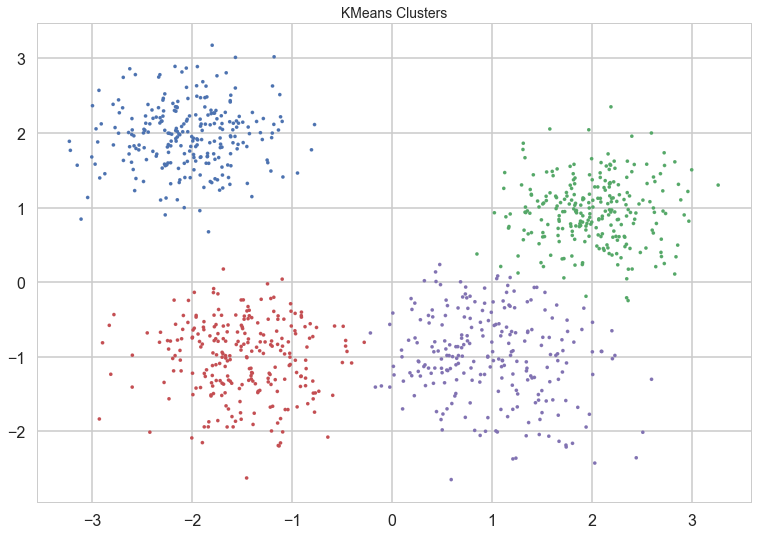

In [45]:
plot_kwargs = {'s': 12, 'linewidths': 0.1}
unsupervised_learner.plot_clusters(KMeans,
                                   X,
                                   unsupervised_learner.predictions[0]['KMeans'],
                                   plot_kwargs)

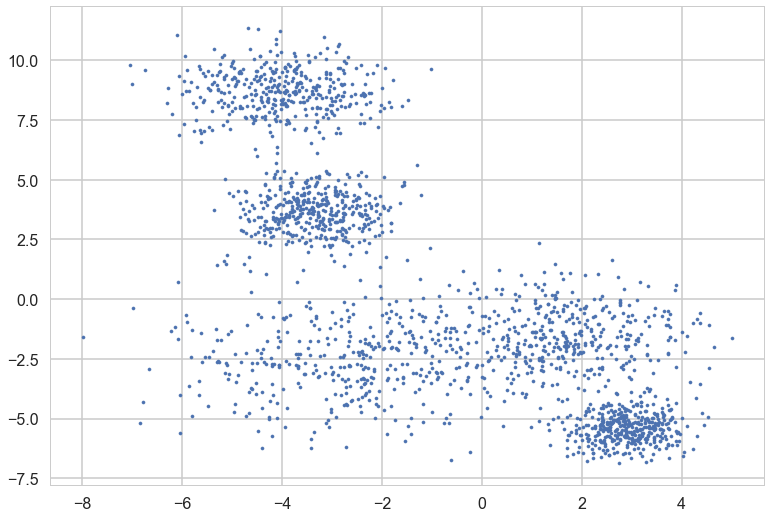

In [46]:
X, y = make_blobs(n_samples=2000, centers=5, cluster_std=[1.7, 0.6, 0.8, 1.0, 1.2], random_state=220)

# Plot sample data
plt.scatter(X[:, 0], X[:, 1], **plot_kwargs)
plt.show()

In [47]:
from sklearn.cluster import KMeans

estimators = [{'estimator': KMeans, 'args':(), 'kwargs':{'n_clusters': 4}}]

unsupervised_learner = Unsupervised_AutoML(estimators)

predictions, performance_metrics = unsupervised_learner.fit_predict(X, y)


################## KMeans metrics #####################
	Silhouette Coefficient: 0.549
	Estimated number of clusters: 4.000
	Homogeneity: 0.729
	Completeness: 0.873
	V-measure: 0.795
	Adjusted Rand Index: 0.702
	Adjusted Mutual Information: 0.729


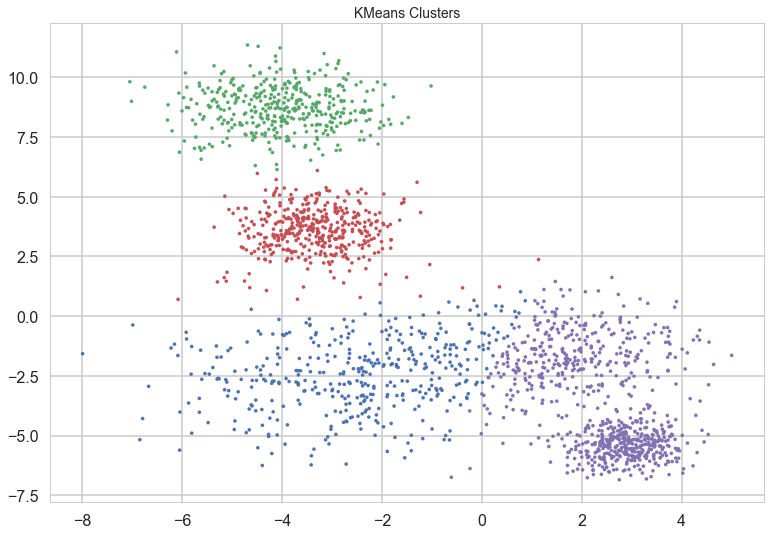

In [48]:
plot_kwargs = {'s': 12, 'linewidths': 0.1}
unsupervised_learner.plot_clusters(KMeans,
                                   X,
                                   unsupervised_learner.predictions[0]['KMeans'],
                                   plot_kwargs)

#### DBSCAN

In [49]:
from sklearn.cluster import DBSCAN

estimators = [{'estimator': DBSCAN, 'args':(), 'kwargs':{'eps': 0.5}}]

unsupervised_learner = Unsupervised_AutoML(estimators)

predictions, performance_metrics = unsupervised_learner.fit_predict(X, y)

################## DBSCAN metrics #####################
	Silhouette Coefficient: 0.417
	Estimated number of clusters: 5.000
	Homogeneity: 0.571
	Completeness: 0.841
	V-measure: 0.680
	Adjusted Rand Index: 0.469
	Adjusted Mutual Information: 0.569


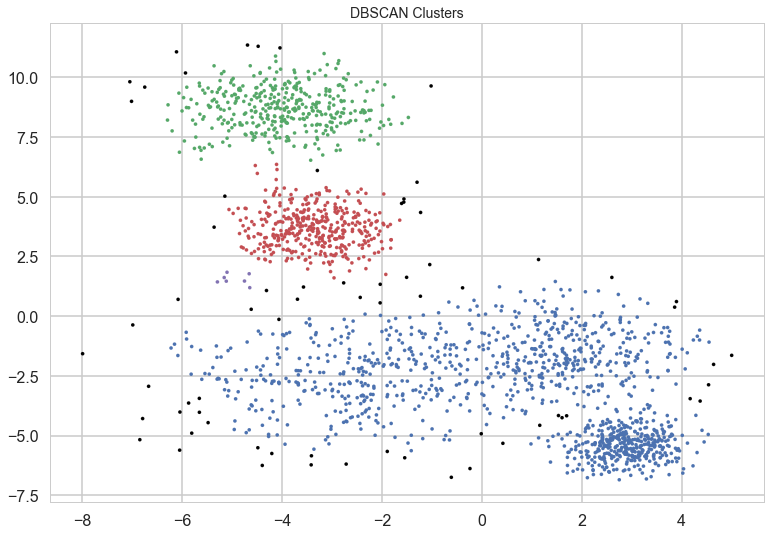

In [50]:
plot_kwargs = {'s': 12, 'linewidths': 0.1}
unsupervised_learner.plot_clusters(DBSCAN,
                                   X,
                                   unsupervised_learner.predictions[0]['DBSCAN'],
                                   plot_kwargs)

#### Agglomerative Clustering

In [51]:
from sklearn.cluster import AgglomerativeClustering

estimators = [{'estimator': AgglomerativeClustering, 'args':(), 'kwargs':{'n_clusters': 4, 'linkage': 'ward'}}]

unsupervised_learner = Unsupervised_AutoML(estimators)

predictions, performance_metrics = unsupervised_learner.fit_predict(X, y)

################## AgglomerativeClustering metrics #####################
	Silhouette Coefficient: 0.546
	Estimated number of clusters: 4.000
	Homogeneity: 0.751
	Completeness: 0.905
	V-measure: 0.820
	Adjusted Rand Index: 0.719
	Adjusted Mutual Information: 0.750


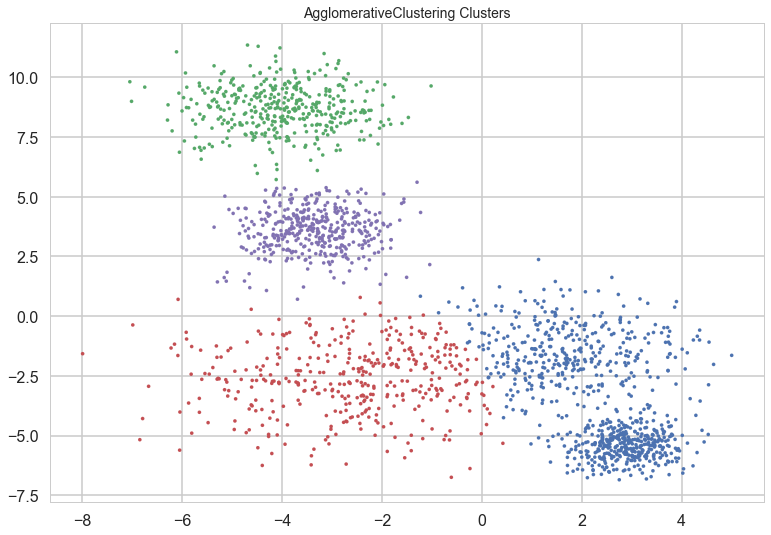

In [52]:
plot_kwargs = {'s': 12, 'linewidths': 0.1}
unsupervised_learner.plot_clusters(AgglomerativeClustering,
                                   X,
                                   unsupervised_learner.predictions[0]['AgglomerativeClustering'],
                                   plot_kwargs)

### Simple automation of unsupervised learning

In [56]:
# You will create a list of algorithms to test
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering
from hdbscan import HDBSCAN

# bandwidth estimate for MeanShift algorithm to work properly
bandwidth = estimate_bandwidth(X, quantile=0.3, n_samples=100)

estimators = [{'estimator': KMeans, 'args': (), 'kwargs': {'n_clusters': 5}},
                         {'estimator': DBSCAN, 'args': (), 'kwargs': {'eps': 0.5}},
                         {'estimator': AgglomerativeClustering, 'args': (), 'kwargs': {'n_clusters': 5, 'linkage': 'ward'}},
                         {'estimator': MeanShift, 'args': (), 'kwargs': {'cluster_all': False, "bandwidth": bandwidth, "bin_seeding": True}},
                         {'estimator': SpectralClustering, 'args': (), 'kwargs': {'n_clusters':5}},
                         {'estimator': HDBSCAN, 'args': (), 'kwargs': {'min_cluster_size':15}}]


unsupervised_learner = Unsupervised_AutoML(estimators)

predictions, performance_metrics = unsupervised_learner.fit_predict(X, y)

################## KMeans metrics #####################
	Silhouette Coefficient: 0.592
	Estimated number of clusters: 5.000
	Homogeneity: 0.881
	Completeness: 0.882
	V-measure: 0.882
	Adjusted Rand Index: 0.886
	Adjusted Mutual Information: 0.881
################## DBSCAN metrics #####################
	Silhouette Coefficient: 0.417
	Estimated number of clusters: 5.000
	Homogeneity: 0.571
	Completeness: 0.841
	V-measure: 0.680
	Adjusted Rand Index: 0.469
	Adjusted Mutual Information: 0.569
################## AgglomerativeClustering metrics #####################
	Silhouette Coefficient: 0.581
	Estimated number of clusters: 5.000
	Homogeneity: 0.899
	Completeness: 0.899
	V-measure: 0.899
	Adjusted Rand Index: 0.907
	Adjusted Mutual Information: 0.899
################## MeanShift metrics #####################
	Silhouette Coefficient: 0.472
	Estimated number of clusters: 3.000
	Homogeneity: 0.458
	Completeness: 0.765
	V-measure: 0.573
	Adjusted Rand Index: 0.404
	Adjusted Mutual Information

In [57]:
pprint(predictions)

[{'KMeans': array([1, 4, 3, ..., 2, 4, 0], dtype=int32)},
 {'DBSCAN': array([ 0,  0,  0, ...,  2, -1,  1])},
 {'AgglomerativeClustering': array([2, 4, 0, ..., 3, 2, 1])},
 {'MeanShift': array([0, 0, 0, ..., 1, 0, 1])},
 {'SpectralClustering': array([4, 2, 3, ..., 1, 3, 0], dtype=int32)},
 {'HDBSCAN': array([ 4,  2,  3, ...,  1, -1,  0])}]


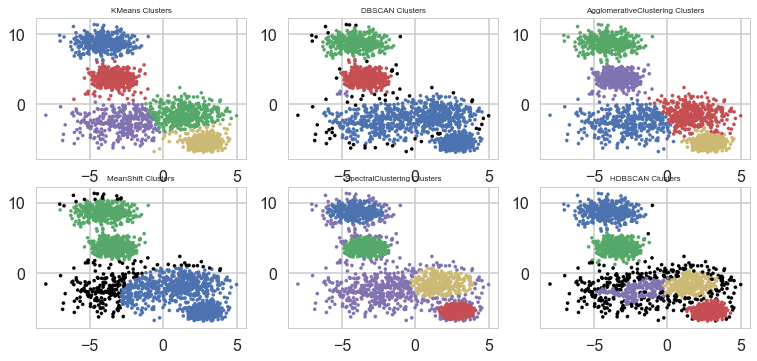

In [58]:
plot_kwargs = {'s': 12, 'linewidths': 0.1}
unsupervised_learner.plot_all_clusters(estimators, unsupervised_learner.predictions, X, plot_kwargs)

### Visualizing high-dimensional datasets

In [59]:
# Wisconsin Breast Cancer Diagnostic Dataset
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
X = data.data

df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [60]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### PCA

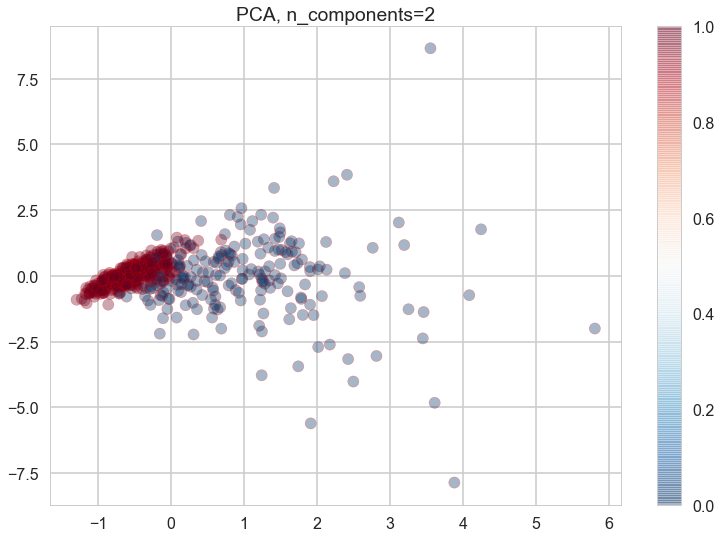

In [61]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
pca = pca.fit_transform(df)

plt.scatter(pca[:, 0], pca[:, 1], c=data.target, cmap="RdBu_r", edgecolor="Red", alpha=0.35)
plt.colorbar()
plt.title('PCA, n_components=2')
plt.show()

In [62]:
# Pre-process data.
scaler = StandardScaler()
scaler.fit(df)
preprocessed_data = scaler.transform(df)
scaled_features_df = pd.DataFrame(preprocessed_data, index=df.index, columns=df.columns)

In [63]:
scaled_features_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-3.162867e-15,-6.530609e-15,-7.078891e-16,-8.799835e-16,6.132177e-15,-1.120369e-15,-4.421380e-16,9.732500e-16,-1.971670e-15,-1.453631e-15,...,-2.333224e-15,1.763674e-15,-1.198026e-15,5.049661e-16,-5.213170e-15,-2.174788e-15,6.856456e-16,-1.412656e-16,-2.289567e-15,2.575171e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-6.749213e-01,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-2.690395e-01,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,5.220158e-01,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,4.094189e+00,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


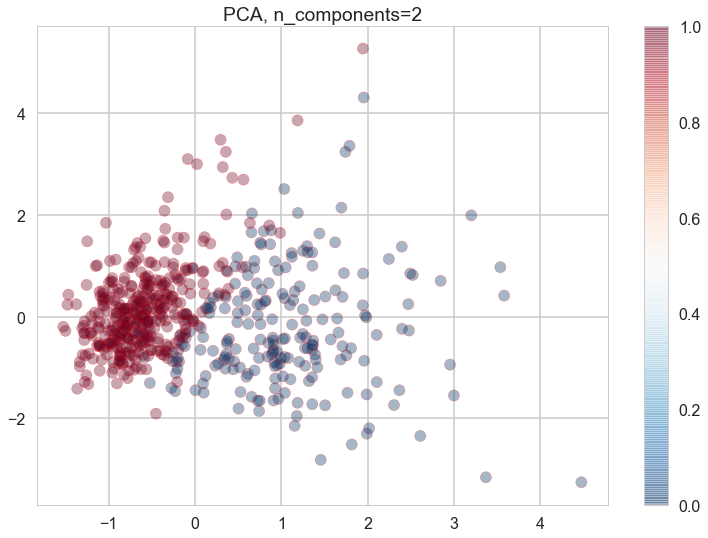

In [64]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
pca = pca.fit_transform(scaled_features_df)

plt.scatter(pca[:, 0], pca[:, 1], c=data.target, cmap="RdBu_r", edgecolor="Red", alpha=0.35)
plt.colorbar()
plt.title('PCA, n_components=2')
plt.show()

#### t-SNE

In [69]:
# TSNE
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=40, n_iter=4000)
tsne = tsne.fit_transform(df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.000s...
[t-SNE] Computed neighbors for 569 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 33.679703
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.151775
[t-SNE] Error after 4000 iterations: 0.209123


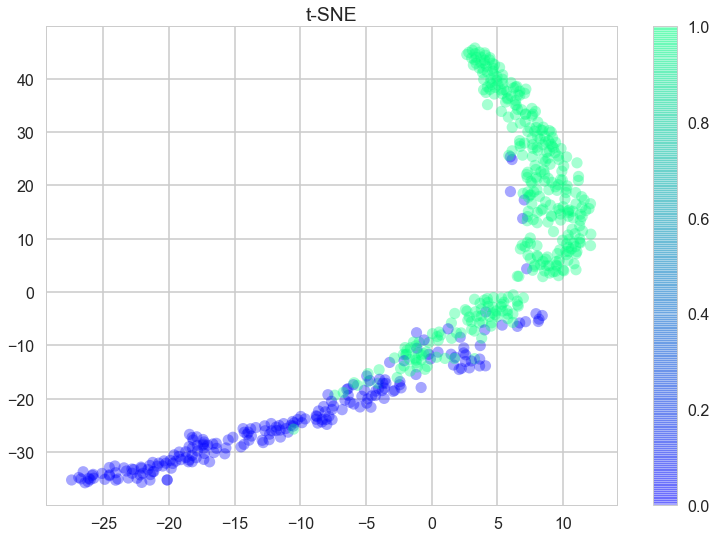

In [70]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=data.target, cmap="winter", edgecolor="None", alpha=0.35)
plt.colorbar()
plt.title('t-SNE')
plt.show()

In [67]:
tsne = TSNE(verbose=1, perplexity=40, n_iter=4000)
tsne = tsne.fit_transform(scaled_features_df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.000s...
[t-SNE] Computed neighbors for 569 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 1.522404
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.367111
[t-SNE] Error after 1550 iterations: 0.888055


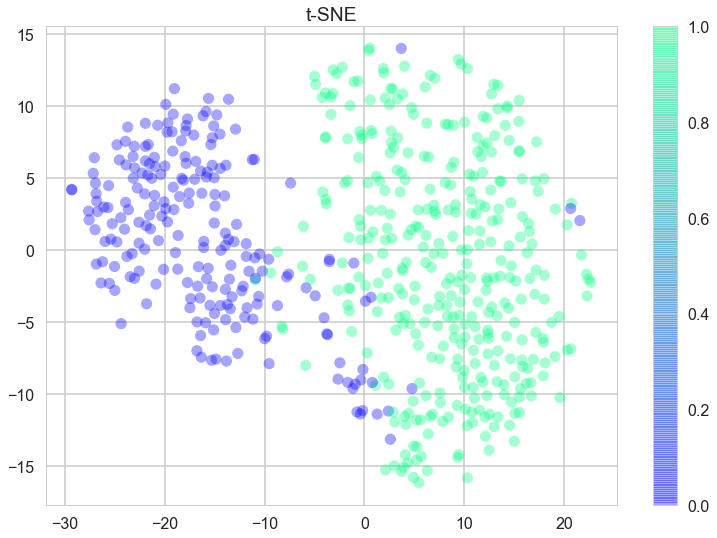

In [68]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=data.target, cmap="winter", edgecolor="None", alpha=0.35)
plt.colorbar()
plt.title('t-SNE')
plt.show()

### Adding simple components together to improve the pipeline

Final version of Unsupervised_AutoML class

In [71]:
class Unsupervised_AutoML:

    def __init__(self, estimators=None, transformers=None):
        self.estimators = estimators
        self.transformers = transformers
        pass

    def fit_predict(self, X, y=None, scaler=True, decomposer={'name': PCA, 'args':[], 'kwargs': {'n_components': 2}}):
        """
        fit_predict will train given estimator(s) and predict cluster membership for each sample
        """

        shape = X.shape
        df_type = isinstance(X, pd.core.frame.DataFrame)

        if df_type:
            column_names = X.columns
            index = X.index

        if scaler == True:
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            if df_type:
                X = pd.DataFrame(X, index=index, columns=column_names)

        if decomposer is not None:
            X = decomposer['name'](*decomposer['args'], **decomposer['kwargs']).fit_transform(X)

            if df_type:
                if decomposer['name'].__name__ == 'PCA':
                    X = pd.DataFrame(X, index=index, columns=['component_' + str(i + 1) for i in
                                                              range(decomposer['kwargs']['n_components'])])
                else:
                    X = pd.DataFrame(X, index=index, columns=['component_1', 'component_2'])

            # if dimensionality reduction is applied, then n_components will be set accordingly in hyperparameter configuration
            for estimator in self.estimators:
                if 'n_clusters' in estimator['kwargs'].keys():
                    if decomposer['name'].__name__ == 'PCA':
                        estimator['kwargs']['n_clusters'] = decomposer['kwargs']['n_components']
                    else:
                        estimator['kwargs']['n_clusters'] = 2

        # This dictionary will hold predictions for each estimator
        predictions = []
        performance_metrics = {}

        for estimator in self.estimators:
            labels = estimator['estimator'](*estimator['args'], **estimator['kwargs']).fit_predict(X)
            estimator['estimator'].n_clusters_ = len(np.unique(labels))
            metrics = self._get_cluster_metrics(estimator['estimator'].__name__, estimator['estimator'].n_clusters_, X, labels, y)
            predictions.append({estimator['estimator'].__name__: labels})
            performance_metrics[estimator['estimator'].__name__] = metrics

        self.predictions = predictions
        self.performance_metrics = performance_metrics

        return predictions, performance_metrics

    # Printing cluster metrics for given arguments
    def _get_cluster_metrics(self, name, n_clusters_, X, pred_labels, true_labels=None):
        from sklearn.metrics import homogeneity_score, \
            completeness_score, \
            v_measure_score, \
            adjusted_rand_score, \
            adjusted_mutual_info_score, \
            silhouette_score

        print("""################## %s metrics #####################""" % name)
        if len(np.unique(pred_labels)) >= 2:

            silh_co = silhouette_score(X, pred_labels)

            if true_labels is not None:

                h_score = homogeneity_score(true_labels, pred_labels)
                c_score = completeness_score(true_labels, pred_labels)
                vm_score = v_measure_score(true_labels, pred_labels)
                adj_r_score = adjusted_rand_score(true_labels, pred_labels)
                adj_mut_info_score = adjusted_mutual_info_score(true_labels, pred_labels)

                metrics = {"Silhouette Coefficient": silh_co,
                           "Estimated number of clusters": n_clusters_,
                           "Homogeneity": h_score,
                           "Completeness": c_score,
                           "V-measure": vm_score,
                           "Adjusted Rand Index": adj_r_score,
                           "Adjusted Mutual Information": adj_mut_info_score}

                for k, v in metrics.items():
                    print("\t%s: %0.3f" % (k, v))

                return metrics

            metrics = {"Silhouette Coefficient": silh_co,
                       "Estimated number of clusters": n_clusters_}

            for k, v in metrics.items():
                print("\t%s: %0.3f" % (k, v))

            return metrics

        else:
            print("\t# of predicted labels is {}, can not produce metrics. \n".format(np.unique(pred_labels)))

    # plot_clusters will visualize the clusters given predicted labels
    def plot_clusters(self, estimator, X, labels, plot_kwargs):

        palette = sns.color_palette('deep', np.unique(labels).max() + 1)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

        plt.scatter(X[:, 0], X[:, 1], c=colors, **plot_kwargs)
        plt.title('{} Clusters'.format(str(estimator.__name__)), fontsize=14)
        plt.show()

    def plot_all_clusters(self, estimators, labels, X, plot_kwargs):

        fig = plt.figure()

        for i, algorithm in enumerate(labels):

            quotinent = np.divide(len(estimators), 2)

            # Simple logic to decide row and column size of the figure
            if isinstance(quotinent, int):
                dim_1 = 2
                dim_2 = quotinent
            else:
                dim_1 = np.ceil(quotinent)
                dim_2 = 3

            palette = sns.color_palette('deep',
                                        np.unique(algorithm[estimators[i]['estimator'].__name__]).max() + 1)
            colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in
                      algorithm[estimators[i]['estimator'].__name__]]

            plt.subplot(dim_1, dim_2, i + 1)
            plt.scatter(X[:, 0], X[:, 1], c=colors, **plot_kwargs)
            plt.title('{} Clusters'.format(str(estimators[i]['estimator'].__name__)), fontsize=8)

        plt.show()

In [72]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth, SpectralClustering
from hdbscan import HDBSCAN

from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data
y = data.target

# Necessary for bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=100)

estimators = [{'estimator': KMeans, 'args': (), 'kwargs': {'n_clusters': 5}},
                         {'estimator': DBSCAN, 'args': (), 'kwargs': {'eps': 0.3}},
                         {'estimator': AgglomerativeClustering, 'args': (), 'kwargs': {'n_clusters': 5, 'linkage': 'ward'}},
                         {'estimator': MeanShift, 'args': (), 'kwargs': {'cluster_all': False, "bandwidth": bandwidth, "bin_seeding": True}},
                         {'estimator': SpectralClustering, 'args': (), 'kwargs': {'n_clusters':5}},
                         {'estimator': HDBSCAN, 'args': (), 'kwargs': {'min_cluster_size':15}}]

unsupervised_learner = Unsupervised_AutoML(estimators)

predictions, performance_metrics = unsupervised_learner.fit_predict(X, y, decomposer=None)

################## KMeans metrics #####################
	Silhouette Coefficient: 0.166
	Estimated number of clusters: 5.000
	Homogeneity: 0.647
	Completeness: 0.294
	V-measure: 0.404
	Adjusted Rand Index: 0.335
	Adjusted Mutual Information: 0.292
################## DBSCAN metrics #####################
	# of predicted labels is [-1], can not produce metrics. 

################## AgglomerativeClustering metrics #####################
	Silhouette Coefficient: 0.243
	Estimated number of clusters: 5.000
	Homogeneity: 0.555
	Completeness: 0.350
	V-measure: 0.429
	Adjusted Rand Index: 0.504
	Adjusted Mutual Information: 0.348
################## MeanShift metrics #####################
	# of predicted labels is [0], can not produce metrics. 

################## SpectralClustering metrics #####################
	Silhouette Coefficient: -0.277
	Estimated number of clusters: 5.000
	Homogeneity: 0.208
	Completeness: 0.181
	V-measure: 0.194
	Adjusted Rand Index: -0.006
	Adjusted Mutual Information: 0.